In [ ]:
# 1. Import Libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
import joblib,random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import datetime
import tensorflow as tf
import matplotlib.dates as mdates  # 📌 UNTUK FORMAT TANGGAL
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Atur seed agar hasil tidak berubah-ubah
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# 1. Mount Google Drive (hanya perlu sekali per sesi)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/data/sahamsent_baru.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])

## Data Understanding

In [ ]:
# 3. Data Understanding
print(df.info())
print(df.describe())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 797 entries, 213 to 212
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           797 non-null    datetime64[ns]
 1   Ticker         797 non-null    object        
 2   Open           797 non-null    float64       
 3   High           797 non-null    float64       
 4   Low            797 non-null    float64       
 5   Close          797 non-null    float64       
 6   Volume         797 non-null    float64       
 7   total_tweet    797 non-null    int64         
 8   positif_tweet  797 non-null    int64         
 9   negatif_tweet  797 non-null    int64         
 10  netral_tweet   797 non-null    int64         
 11  avg_compound   797 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 80.9+ KB
None
                                Date         Open         High          Low  \
count             

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Year'] = df['Date'].dt.year

In [ ]:
stock_names = df["Ticker"].unique()

num_stock_names = len(stock_names)
print(f"Jumlah jenis stock name: {num_stock_names}")

print("Daftar stock name:")
print(stock_names)

Jumlah jenis stock name: 3
Daftar stock name:
['ISAT.JK' 'MDKA.JK' 'TINS.JK']


In [ ]:
stock_counts = df["Ticker"].value_counts()
stock_counts

,count
Ticker,
MDKA.JK,328
ISAT.JK,256
TINS.JK,213


In [ ]:
# Tambahkan kolom 'Month' dan 'Year' untuk gruping
df['YearMonth'] = df['Date'].dt.to_period('M')

In [ ]:
# Tambahkan kolom YearMonth
df['YearMonth'] = df['Date'].dt.to_period('M')

# Ambil data awal dan akhir per bulan secara manual
first_close = df.sort_values('Date').groupby('YearMonth')['Close'].first()
last_close = df.sort_values('Date').groupby('YearMonth')['Close'].last()

# Hitung aggregasi lainnya
monthly_agg = df.groupby('YearMonth').agg({
    'positif_tweet': 'sum',
    'negatif_tweet': 'sum',
    'avg_compound': 'mean'
}).reset_index()

# Gabungkan semua hasil ke dataframe akhir
monthly_agg['Harga_Awal'] = first_close.values
monthly_agg['Harga_Akhir'] = last_close.values
monthly_agg['Kenaikan_Harga_%'] = ((monthly_agg['Harga_Akhir'] - monthly_agg['Harga_Awal']) / monthly_agg['Harga_Awal'])

# Urutkan kolom agar lebih rapi
monthly_analysis = monthly_agg[[
    'YearMonth', 'Harga_Awal', 'Harga_Akhir', 'Kenaikan_Harga_%',
    'positif_tweet', 'negatif_tweet', 'avg_compound'
]].rename(columns={
    'positif_tweet': 'Sentimen_Positif',
    'negatif_tweet': 'Sentimen_Negatif',
    'avg_compound': 'Rata2_Compound'
})
display(monthly_analysis)


,YearMonth,Harga_Awal,Harga_Akhir,Kenaikan_Harga_%,Sentimen_Positif,Sentimen_Negatif,Rata2_Compound
0,2019-01,347.079747,858.398613,1.473203,0,0,0.000000
1,2019-02,723.519659,786.434462,0.086957,3,0,0.169862
2,2019-04,488.637953,488.637953,0.000000,0,0,0.000000
3,2019-05,416.286010,370.148501,-0.110831,1,0,0.386950
4,2019-06,503.318087,503.318087,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...
72,2025-02,2220.000000,1710.000000,-0.229730,17,6,0.114783
73,2025-03,1480.000000,905.000000,-0.388514,9,5,0.176880
74,2025-05,1814.579956,2020.000000,0.113205,19,4,0.280564
75,2025-06,2120.000000,2000.000000,-0.056604,33,10,0.229172


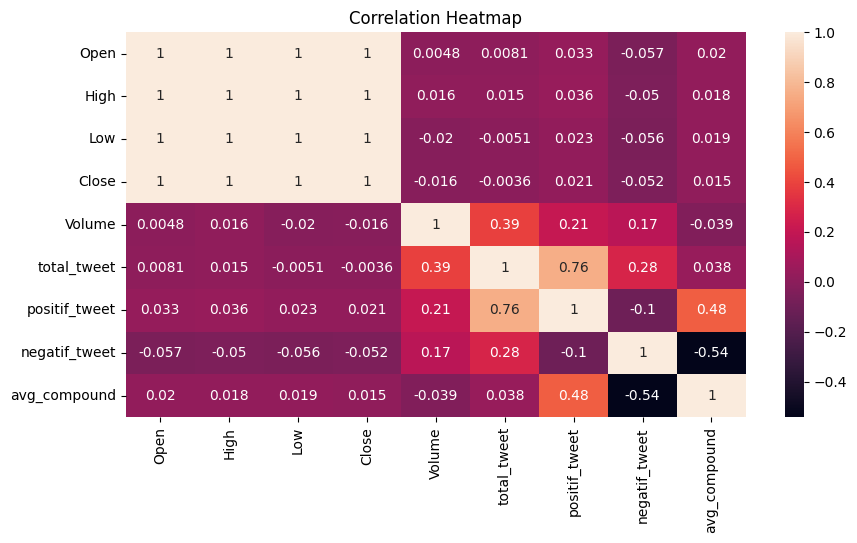

In [ ]:
# 5. EDA
plt.figure(figsize=(10,5))
sns.heatmap(df[['Open','High','Low','Close','Volume','total_tweet','positif_tweet','negatif_tweet','avg_compound']].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

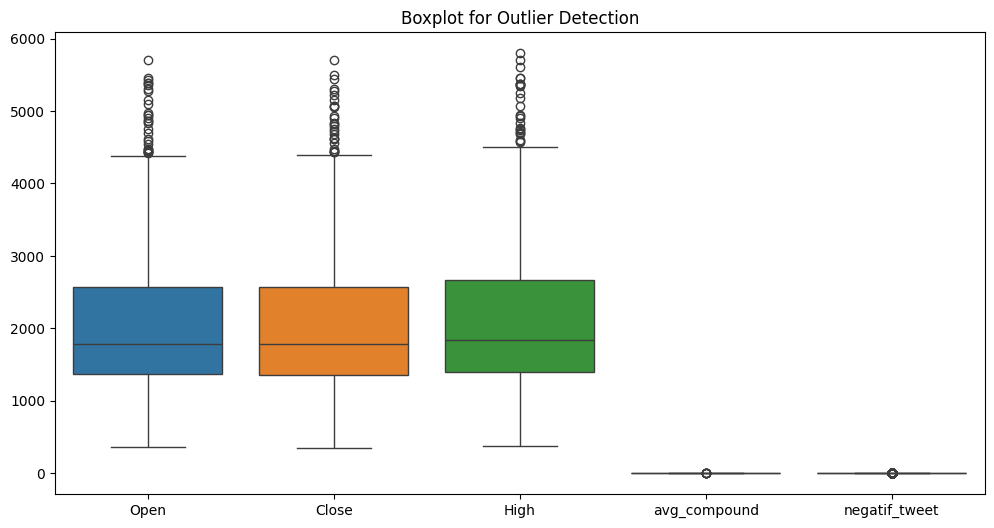

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Open','Close','High','avg_compound','negatif_tweet']])
plt.title("Boxplot for Outlier Detection")
plt.show()

In [ ]:
# Penanganan outlier dengan trasformasi data
df['Open_log'] = np.log1p(df['Open'])
df['Close_log'] = np.log1p(df['Close'])
df['High_log'] = np.log1p(df['High'])

In [ ]:
from scipy.stats.mstats import winsorize
df['avg_compound_winsor'] = winsorize(df['avg_compound'], limits=[0.05, 0.05])
df['positif_tweet_winsor'] = winsorize(df['positif_tweet'], limits=[0.9, 0.05])
df['negatif_tweet_winsor'] = winsorize(df['negatif_tweet'], limits=[0.9, 0.05])

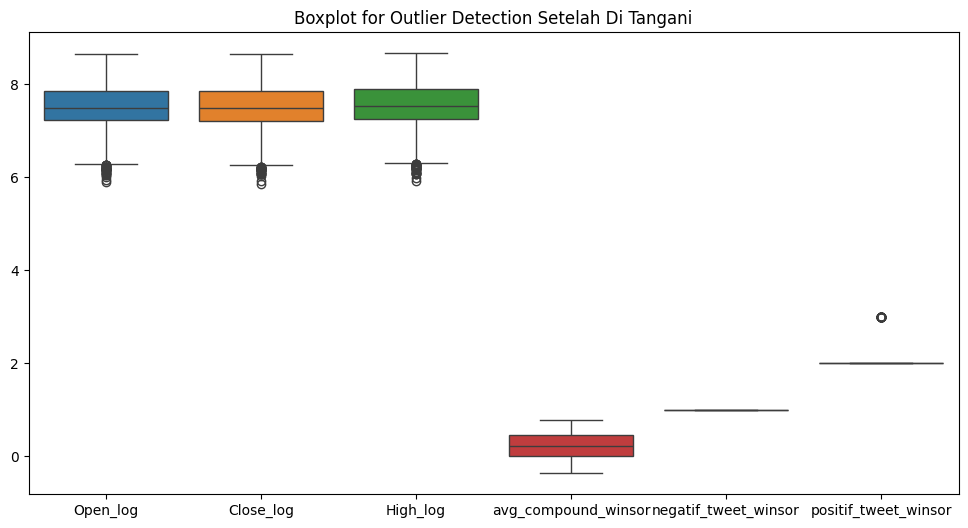

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Open_log','Close_log','High_log','avg_compound_winsor','negatif_tweet_winsor','positif_tweet_winsor']])
plt.title("Boxplot for Outlier Detection Setelah Di Tangani")
plt.show()

In [ ]:
# 4b. Cek Konsistensi Harga 📌
invalid_close = df[df['Close'] < 0]
if not invalid_close.empty:
    print("Data dengan Close < 0 ditemukan:")
    print(invalid_close)
else:
    print("✅ Tidak ditemukan data dengan Close < 0")

✅ Tidak ditemukan data dengan Close < 0


In [ ]:
unreasonable_jump = df.copy()
unreasonable_jump['prev_close'] = unreasonable_jump.groupby('Ticker')['Close'].shift(1)
unreasonable_jump['pct_change'] = (unreasonable_jump['Close'] - unreasonable_jump['prev_close']) / unreasonable_jump['prev_close'] * 100
outliers = unreasonable_jump[np.abs(unreasonable_jump['pct_change']) > 1000]
if not outliers.empty:
    print("Data dengan lonjakan Close > 1000% ditemukan:")
    print(outliers)
else:
    print("✅ Tidak ditemukan lonjakan harga > 1000%")

✅ Tidak ditemukan lonjakan harga > 1000%


In [ ]:
inconsistent_ohlc = df[(df['Close'] > df['High']) | (df['Close'] < df['Low'])]
if not inconsistent_ohlc.empty:
    print("Data Close tidak konsisten dengan High/Low:")
    print(inconsistent_ohlc)

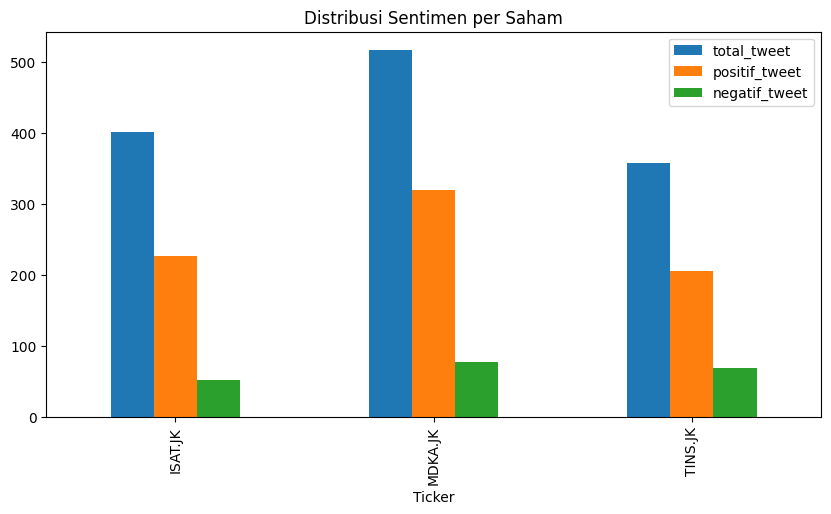

In [ ]:
# Distribusi sentimen
df.groupby(['Ticker'])[['total_tweet','positif_tweet','negatif_tweet']].sum().plot(kind='bar', figsize=(10,5))
plt.title("Distribusi Sentimen per Saham")
plt.show()


In [ ]:
TICKERS = df['Ticker'].unique()

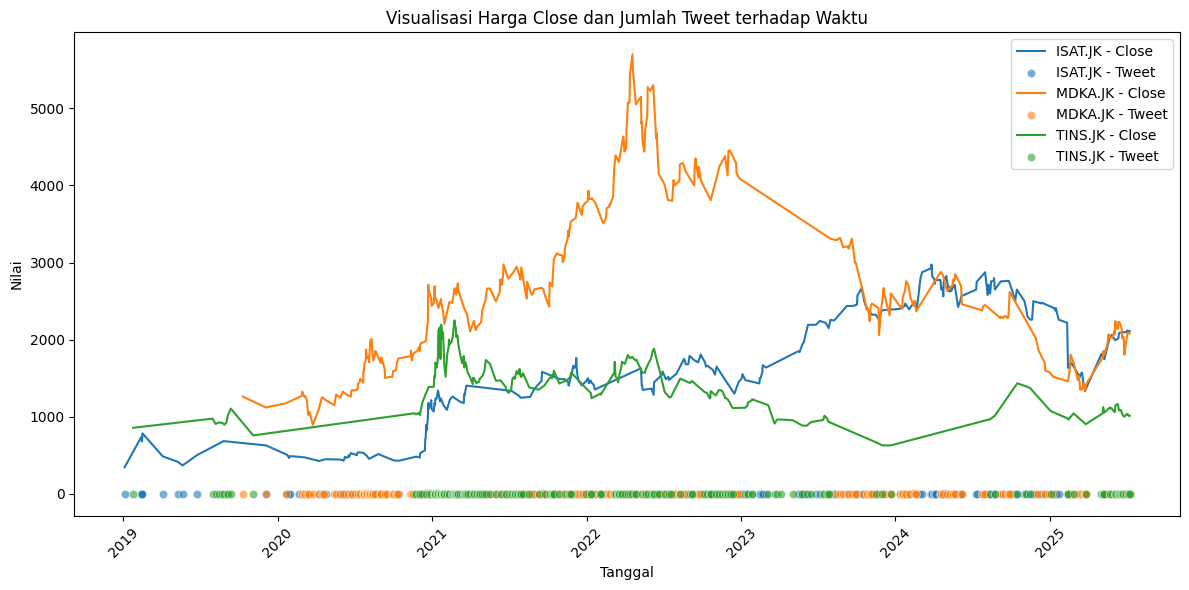

In [ ]:
# Visualisasi ekstrem harga vs total tweet
plt.figure(figsize=(12,6))
for ticker in TICKERS:
    subset = df[df['Ticker'] == ticker]
    sns.lineplot(x='Date', y='Close', data=subset, label=f"{ticker} - Close")
    sns.scatterplot(x='Date', y='total_tweet', data=subset, label=f"{ticker} - Tweet", marker='o', alpha=0.6)
plt.title("Visualisasi Harga Close dan Jumlah Tweet terhadap Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

menambahkan fitur baru

*close_lag1* = harga penutupan 1 hari sebelumnya

In [ ]:
# Urutkan berdasarkan Ticker dan Date
df = df.sort_values(['Ticker', 'Date'])

# Tambahkan fitur lag dan rolling hanya berdasarkan grup saham
df['Close_lag1'] = df.groupby('Ticker')['Close'].shift(1)

In [ ]:
# Hapus baris dengan nilai NaN akibat shift/rolling di awal
df = df.dropna().reset_index(drop=True)

In [ ]:
# 5. Simpan ke file CSV
df.to_csv("saham_with_lag1.csv", index=False)

In [ ]:
df_lag = pd.read_csv("saham_with_lag1.csv")

## Data Preparation

### Menyimpan split dan scaler

In [ ]:
ticker = 'TINS.JK'  # Ganti sesuai ticker yang ingin diuji

data = df_lag[df_lag['Ticker'] == ticker].copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

feature_cols = ['Open_log', 'High_log', 'negatif_tweet', 'Close_lag1']
target_col = ['Close_log']

# Sequence windowing
window = 3

raw_X = data[feature_cols].values
raw_y = data[target_col].values

X, y, dates = [], [], data.index[window:]
for i in range(window, len(data)):
    X.append(raw_X[i-window:i])
    y.append(raw_y[i])
X, y = np.array(X), np.array(y)

# Split data
total_samples = len(X)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.1)

X_train_raw = X[:train_size]
X_val_raw = X[train_size:train_size+val_size]
X_test_raw = X[total_samples - (total_samples - train_size - val_size):] # Corrected test size indexing

y_train_raw = y[:train_size]
y_val_raw = y[train_size:train_size+val_size]
y_test_raw = y[total_samples - (total_samples - train_size - val_size):] # Corrected test size indexing

#Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
X_val = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)


y_train = scaler_y.fit_transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

# === SIMPAN SPLIT DAN SCALER ===
save_path = f"/content/drive/MyDrive/model_lstm/{ticker}_win3"
os.makedirs(save_path, exist_ok=True)

# Simpan data split
dates_test = dates[train_size+val_size:] # Define dates_test here
np.savez(f"{save_path}/split_data.npz",
         X_train=X_train, X_val=X_val, X_test=X_test,
         y_train=y_train, y_val=y_val, y_test=y_test,
         dates_test=dates_test)

# Simpan scaler
joblib.dump(scaler_X, f"{save_path}/scaler_X.pkl")
joblib.dump(scaler_y, f"{save_path}/scaler_y.pkl")

print(f"✅ Split dan Scaler untuk {ticker} berhasil disimpan.")

✅ Split dan Scaler untuk TINS.JK berhasil disimpan.


In [ ]:
dates_train = dates[:train_size]
dates_val = dates[train_size:train_size+val_size]
dates_test = dates[train_size+val_size:]

print(f"Tanggal Train: {dates_train.min()} -> {dates_train.max()}")
print(f"Tanggal Val  : {dates_val.min()} -> {dates_val.max()}")
print(f"Tanggal Test : {dates_test.min()} -> {dates_test.max()}")

Tanggal Train: 2019-08-23 00:00:00 -> 2022-11-09 00:00:00
Tanggal Val  : 2022-11-17 00:00:00 -> 2023-06-05 00:00:00
Tanggal Test : 2023-06-15 00:00:00 -> 2025-07-08 00:00:00


### PERSIAPAN Struktur

In [ ]:
# Siapkan struktur penyimpanan
results = {}
visuals = {}
histories = {}

# Tentukan daftar ticker
TICKERS = df_lag['Ticker'].unique()

### Saham TINS

In [ ]:
ticker = 'TINS.JK'  # Ganti dengan saham yang ingin kamu prediksi
load_path = f"/content/drive/MyDrive/model_lstm/{ticker}_win3"

# Load data split
data = np.load(f"{load_path}/split_data.npz")
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
dates_test = data['dates_test']

# Load scaler
scaler_X = joblib.load(f"{load_path}/scaler_X.pkl")
scaler_y = joblib.load(f"{load_path}/scaler_y.pkl")

print(f"✅ Data dan Scaler untuk {ticker} berhasil dimuat dari Drive.")


✅ Data dan Scaler untuk TINS.JK berhasil dimuat dari Drive.


In [ ]:
print(f"Data split — Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
model = Sequential(name=f"LSTM_{ticker}")
model.add(LSTM(units=32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Data split — Train: 146, Val: 20, Test: 43


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_TINS.JK"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=4,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

histories[ticker] = pd.DataFrame(history.history)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1373 - mae: 0.3244 - val_loss: 0.0162 - val_mae: 0.1071
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - mae: 0.0706 - val_loss: 0.0095 - val_mae: 0.0740
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - mae: 0.0710 - val_loss: 0.0108 - val_mae: 0.0796
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mae: 0.0689 - val_loss: 0.0104 - val_mae: 0.0777
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - mae: 0.0681 - val_loss: 0.0100 - val_mae: 0.0762
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - mae: 0.0675 - val_loss: 0.0098 - val_mae: 0.0749
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - mae: 0.0668 - val_loss: 0.0095 - val_mae: 0.0736
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.0663 - val_loss: 0.0093 - val_mae: 0.0724
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi di masing-masing split
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse jika target di-scaling
y_train_actual = np.exp(scaler_y.inverse_transform(y_train))
y_train_pred = np.exp(scaler_y.inverse_transform(y_train_pred.reshape(-1,1)))

y_val_actual = np.exp(scaler_y.inverse_transform(y_val))
y_val_pred = np.exp(scaler_y.inverse_transform(y_val_pred.reshape(-1,1)))

y_test_actual = np.exp(scaler_y.inverse_transform(y_test))
y_test_pred = np.exp(scaler_y.inverse_transform(y_test_pred.reshape(-1,1)))


# Hitung metrik
def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

evaluate(y_train_actual, y_train_pred, "Train")
evaluate(y_val_actual, y_val_pred, "Validation")
evaluate(y_test_actual, y_test_pred, "Test")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Train RMSE: 77.94, MAE: 53.96, R2: 0.93
Validation RMSE: 71.37, MAE: 44.06, R2: 0.72
Test RMSE: 118.67, MAE: 77.06, R2: 0.41


In [ ]:
y_pred = model.predict(X_test)

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}")

results[ticker] = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

visuals[ticker] = {
    'y_test': y_test_inv.flatten(),
    'y_pred': y_pred_inv.flatten(),
    'dates': dates_test
}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MSE: 0.01, RMSE: 0.12, R²: 0.43, MAE: 0.08


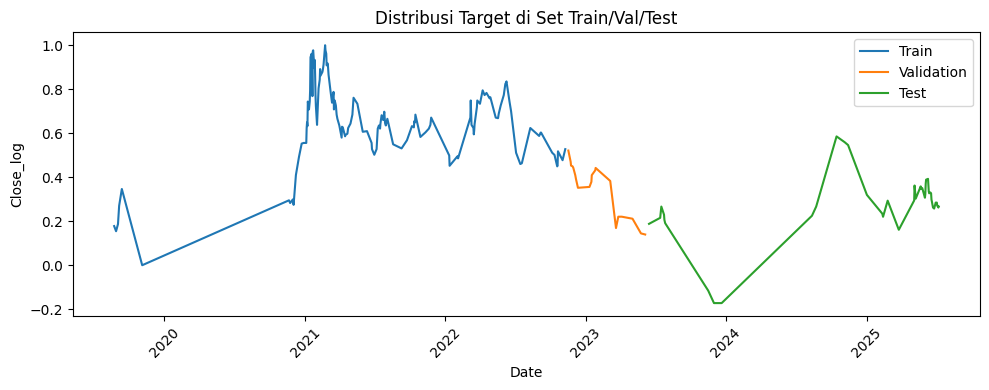

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(dates_train, y_train, label='Train')
plt.plot(dates_val, y_val, label='Validation')
plt.plot(dates_test, y_test, label='Test')

plt.xlabel('Date')
plt.ylabel('Close_log')
plt.title('Distribusi Target di Set Train/Val/Test')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

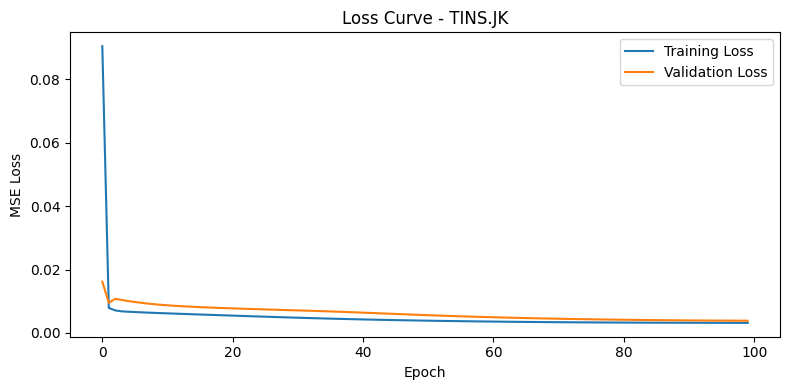

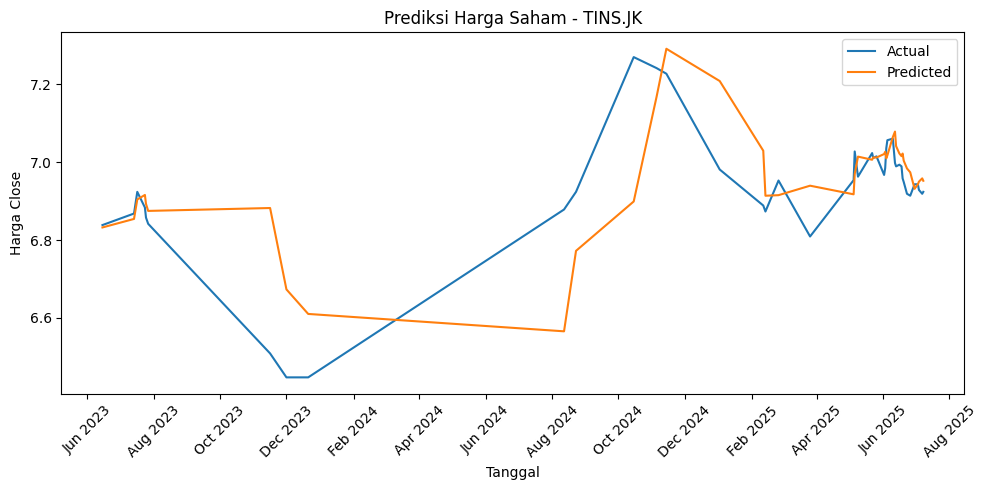

In [ ]:
# Loss History
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve - {ticker}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Prediksi
plt.figure(figsize=(10, 5))
plt.plot(dates_test, visuals[ticker]['y_test'], label='Actual')
plt.plot(dates_test, visuals[ticker]['y_pred'], label='Predicted')
plt.title(f"Prediksi Harga Saham - {ticker}")
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Simpan ke Google Drive
model.save("tins_model2.h5", include_optimizer=False, save_format="h5")


### Saham MDKA

In [ ]:
ticker = 'MDKA.JK'  # Ganti sesuai ticker yang ingin diuji

data = df_lag[df_lag['Ticker'] == ticker].copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

feature_cols = ['Open_log', 'High_log', 'negatif_tweet', 'Close_lag1']
target_col = ['Close_log']

# Sequence windowing
window = 3

raw_X = data[feature_cols].values
raw_y = data[target_col].values

X, y, dates = [], [], data.index[window:]
for i in range(window, len(data)):
    X.append(raw_X[i-window:i])
    y.append(raw_y[i])
X, y = np.array(X), np.array(y)

# Split data
total_samples = len(X)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.1)

X_train_raw = X[:train_size]
X_val_raw = X[train_size:train_size+val_size]
X_test_raw = X[total_samples - (total_samples - train_size - val_size):] # Corrected test size indexing

y_train_raw = y[:train_size]
y_val_raw = y[train_size:train_size+val_size]
y_test_raw = y[total_samples - (total_samples - train_size - val_size):] # Corrected test size indexing

#Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
X_val = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)


y_train = scaler_y.fit_transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

# === SIMPAN SPLIT DAN SCALER ===
save_path = f"/content/drive/MyDrive/model_lstm/{ticker}_win3"
os.makedirs(save_path, exist_ok=True)

# Simpan data split
dates_test = dates[train_size+val_size:] # Define dates_test here
np.savez(f"{save_path}/split_data.npz",
         X_train=X_train, X_val=X_val, X_test=X_test,
         y_train=y_train, y_val=y_val, y_test=y_test,
         dates_test=dates_test)

# Simpan scaler
joblib.dump(scaler_X, f"{save_path}/scaler_X.pkl")
joblib.dump(scaler_y, f"{save_path}/scaler_y.pkl")

print(f"✅ Split dan Scaler untuk {ticker} berhasil disimpan.")

✅ Split dan Scaler untuk MDKA.JK berhasil disimpan.


In [ ]:
dates_train = dates[:train_size]
dates_val = dates[train_size:train_size+val_size]
dates_test = dates[train_size+val_size:]

print(f"Tanggal Train: {dates_train.min()} -> {dates_train.max()}")
print(f"Tanggal Val  : {dates_val.min()} -> {dates_val.max()}")
print(f"Tanggal Test : {dates_test.min()} -> {dates_test.max()}")

Tanggal Train: 2020-02-28 00:00:00 -> 2023-09-12 00:00:00
Tanggal Val  : 2023-09-20 00:00:00 -> 2024-04-22 00:00:00
Tanggal Test : 2024-05-02 00:00:00 -> 2025-07-08 00:00:00


In [ ]:
ticker = 'MDKA.JK'  # Ganti dengan saham yang ingin kamu prediksi
load_path = f"/content/drive/MyDrive/model_lstm/{ticker}_win3"

# Load data split
data = np.load(f"{load_path}/split_data.npz")
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
dates_test = data['dates_test']

# Load scaler
scaler_X = joblib.load(f"{load_path}/scaler_X.pkl")
scaler_y = joblib.load(f"{load_path}/scaler_y.pkl")

print(f"✅ Data dan Scaler untuk {ticker} berhasil dimuat dari Drive.")


✅ Data dan Scaler untuk MDKA.JK berhasil dimuat dari Drive.


In [ ]:
print(f"Data split — Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
model = Sequential(name=f"LSTM_{ticker}")
model.add(LSTM(units=32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Data split — Train: 226, Val: 32, Test: 66


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_MDKA.JK"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=4,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

histories[ticker] = pd.DataFrame(history.history)

Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0278 - mae: 0.1464 - val_loss: 0.0021 - val_mae: 0.0372
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0439 - val_loss: 0.0020 - val_mae: 0.0362
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0400 - val_loss: 0.0019 - val_mae: 0.0350
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - mae: 0.0383 - val_loss: 0.0019 - val_mae: 0.0344
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mae: 0.0365 - val_loss: 0.0018 - val_mae: 0.0341
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mae: 0.0350 - val_loss: 0.0018 - val_mae: 0.0338
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - mae: 0.0338 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0018 - val_mae: 0.0333
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.00

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi di masing-masing split
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse jika target di-scaling
y_train_actual = np.exp(scaler_y.inverse_transform(y_train))
y_train_pred = np.exp(scaler_y.inverse_transform(y_train_pred.reshape(-1,1)))

y_val_actual = np.exp(scaler_y.inverse_transform(y_val))
y_val_pred = np.exp(scaler_y.inverse_transform(y_val_pred.reshape(-1,1)))

y_test_actual = np.exp(scaler_y.inverse_transform(y_test))
y_test_pred = np.exp(scaler_y.inverse_transform(y_test_pred.reshape(-1,1)))


# Hitung metrik
def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

evaluate(y_train_actual, y_train_pred, "Train")
evaluate(y_val_actual, y_val_pred, "Validation")
evaluate(y_test_actual, y_test_pred, "Test")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train RMSE: 264.50, MAE: 186.39, R2: 0.95
Validation RMSE: 195.08, MAE: 153.85, R2: 0.36
Test RMSE: 181.36, MAE: 131.60, R2: 0.80


In [ ]:
y_pred = model.predict(X_test)

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}")

results[ticker] = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

visuals[ticker] = {
    'y_test': y_test_inv.flatten(),
    'y_pred': y_pred_inv.flatten(),
    'dates': dates_test
}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE: 0.01, RMSE: 0.09, R²: 0.79, MAE: 0.07


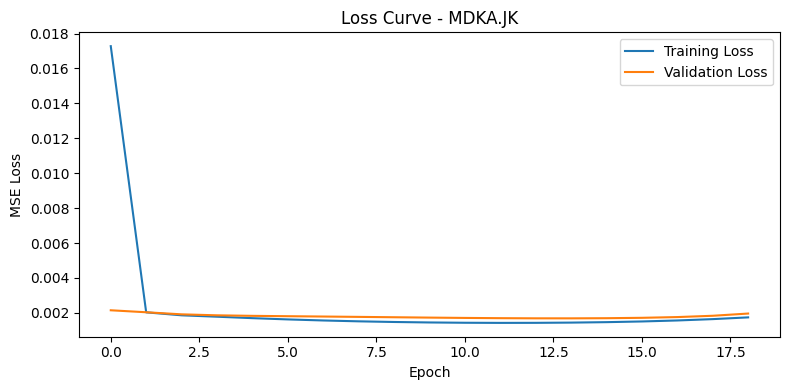

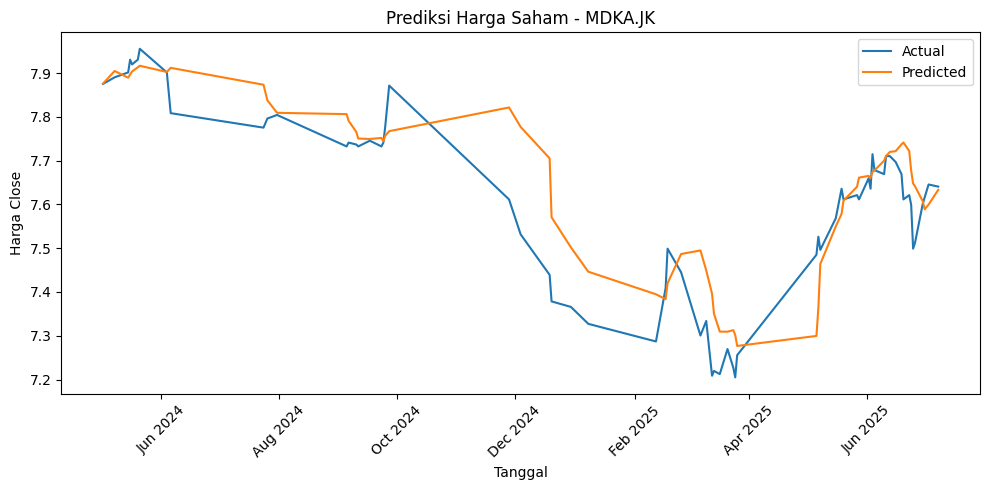

In [ ]:
# Loss History
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve - {ticker}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Prediksi
plt.figure(figsize=(10, 5))
plt.plot(dates_test, visuals[ticker]['y_test'], label='Actual')
plt.plot(dates_test, visuals[ticker]['y_pred'], label='Predicted')
plt.title(f"Prediksi Harga Saham - {ticker}")
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Simpan ke Google Drive
model.save("mdka_model2.h5", include_optimizer=False, save_format="h5")

### Saham ISAT

In [ ]:
ticker = 'ISAT.JK'  # Ganti sesuai ticker yang ingin diuji

data = df_lag[df_lag['Ticker'] == ticker].copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

feature_cols = ['Open_log', 'High_log', 'negatif_tweet', 'Close_lag1']
target_col = ['Close_log']

# Sequence windowing
window = 3

raw_X = data[feature_cols].values
raw_y = data[target_col].values

X, y, dates = [], [], data.index[window:]
for i in range(window, len(data)):
    X.append(raw_X[i-window:i])
    y.append(raw_y[i])
X, y = np.array(X), np.array(y)

# Split data
total_samples = len(X)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.1)

X_train_raw = X[:train_size]
X_val_raw = X[train_size:train_size+val_size]
X_test_raw = X[total_samples - (total_samples - train_size - val_size):] # Corrected test size indexing

y_train_raw = y[:train_size]
y_val_raw = y[train_size:train_size+val_size]
y_test_raw = y[total_samples - (total_samples - train_size - val_size):] # Corrected test size indexing

#Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
X_val = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)


y_train = scaler_y.fit_transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

# === SIMPAN SPLIT DAN SCALER ===
save_path = f"/content/drive/MyDrive/model_lstm/{ticker}_win3"
os.makedirs(save_path, exist_ok=True)

# Simpan data split
dates_test = dates[train_size+val_size:] # Define dates_test here
np.savez(f"{save_path}/split_data.npz",
         X_train=X_train, X_val=X_val, X_test=X_test,
         y_train=y_train, y_val=y_val, y_test=y_test,
         dates_test=dates_test)

# Simpan scaler
joblib.dump(scaler_X, f"{save_path}/scaler_X.pkl")
joblib.dump(scaler_y, f"{save_path}/scaler_y.pkl")

print(f"✅ Split dan Scaler untuk {ticker} berhasil disimpan.")

✅ Split dan Scaler untuk ISAT.JK berhasil disimpan.


In [ ]:
dates_train = dates[:train_size]
dates_val = dates[train_size:train_size+val_size]
dates_test = dates[train_size+val_size:]

print(f"Tanggal Train: {dates_train.min()} -> {dates_train.max()}")
print(f"Tanggal Val  : {dates_val.min()} -> {dates_val.max()}")
print(f"Tanggal Test : {dates_test.min()} -> {dates_test.max()}")

Tanggal Train: 2019-02-15 00:00:00 -> 2024-04-02 00:00:00
Tanggal Val  : 2024-04-03 00:00:00 -> 2024-05-20 00:00:00
Tanggal Test : 2024-05-28 00:00:00 -> 2025-07-08 00:00:00


In [ ]:
ticker = 'ISAT.JK'  # Ganti dengan saham yang ingin kamu prediksi
load_path = f"/content/drive/MyDrive/model_lstmpos/{ticker}_win3"

# Load data split
data = np.load(f"{load_path}/split_data.npz")
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
dates_test = data['dates_test']

# Load scaler
scaler_X = joblib.load(f"{load_path}/scaler_X.pkl")
scaler_y = joblib.load(f"{load_path}/scaler_y.pkl")

print(f"✅ Data dan Scaler untuk {ticker} berhasil dimuat dari Drive.")

✅ Data dan Scaler untuk ISAT.JK berhasil dimuat dari Drive.


In [ ]:
print(f"Data split — Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
model = Sequential(name=f"LSTM_{ticker}")
model.add(LSTM(units=32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Data split — Train: 176, Val: 25, Test: 51


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_ISAT.JK"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=4,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

histories[ticker] = pd.DataFrame(history.history)

Epoch 1/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0061 - mae: 0.0581 - val_loss: 0.0065 - val_mae: 0.0781
Epoch 2/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0331 - mae: 0.1659 - val_loss: 0.0137 - val_mae: 0.1137
Epoch 3/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - mae: 0.1092 - val_loss: 0.0112 - val_mae: 0.0995
Epoch 4/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0682 - val_loss: 0.0059 - val_mae: 0.0654
Epoch 5/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - mae: 0.0593 - val_loss: 0.0035 - val_mae: 0.0434
Epoch 6/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0602 - val_loss: 0.0025 - val_mae: 0.0329
Epoch 7/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - mae: 0.0608 - val_loss: 0.0021 - val_mae: 0.0294
Epoch 8/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mae: 0.0599 - val_loss: 0.0019 - val_mae: 0.0297
Epoch 9/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.00

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi di masing-masing split
y_train_pred_scaled = model.predict(X_train)
y_val_pred_scaled = model.predict(X_val)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform to original scale (undo scaling and then undo log)
# Use the scaler's inverse_transform directly on the scaled predictions and actual values
y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

y_val_actual = scaler_y.inverse_transform(y_val)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


# Hitung metrik
def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

evaluate(y_train_actual, y_train_pred, "Train")
evaluate(y_val_actual, y_val_pred, "Validation")
evaluate(y_test_actual, y_test_pred, "Test")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 140.91, MAE: 116.62, R2: 0.96
Validation RMSE: 111.16, MAE: 82.09, R2: -2.20
Test RMSE: 159.05, MAE: 133.80, R2: 0.84


In [ ]:
y_pred = model.predict(X_test)

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

results[ticker] = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

visuals[ticker] = {
    'y_test': y_test_inv.flatten(),
    'y_pred': y_pred_inv.flatten(),
    'dates': dates_test
}



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
MSE: 25297.57, RMSE: 159.05, MAE: 133.80, R²: 0.84


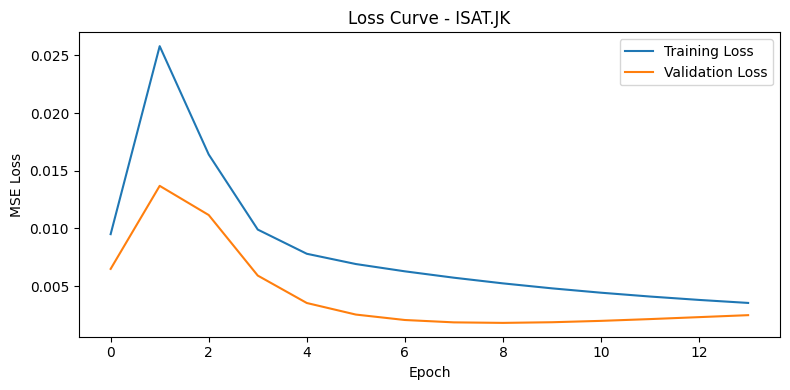

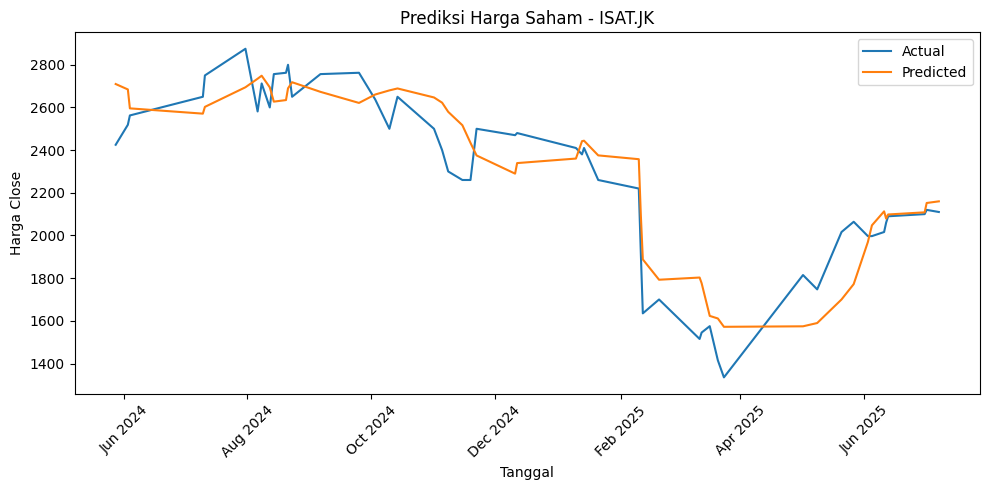

In [ ]:
# Loss History
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve - {ticker}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Prediksi
plt.figure(figsize=(10, 5))
plt.plot(dates_test, visuals[ticker]['y_test'], label='Actual')
plt.plot(dates_test, visuals[ticker]['y_pred'], label='Predicted')
plt.title(f"Prediksi Harga Saham - {ticker}")
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Simpan ke Google Drive
model.save("isat_model2.h5", include_optimizer=False, save_format="h5")